In [10]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [11]:
%matplotlib inline

In [12]:
from relaxed.plot_defaults import *

In [13]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [14]:
from relaxed.analysis import get_mah, add_box_indices, get_tt_indices
from relaxed.models import training_suite
from relaxed import halo_catalogs

# Data

In [15]:
mah_data = get_mah('m12', '../../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [16]:
# catalog
cat = mah_data['cat']
xoff = cat['xoff']
cvir = cat['cvir']
eta = cat['eta']
ma = mah_data['ma']
am = mah_data['am']

scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, eta.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


In [17]:
# add box indices to cat for uncertainty purposes
add_box_indices(cat)

In [18]:
# train/test split
train_idx, test_idx = get_tt_indices(len(cat), test_ratio=0.3)
cat_train, am_train, cvir_train, xoff_train, eta_train = (cat[train_idx], am[train_idx], cvir[train_idx], 
                                                           xoff[train_idx], eta[train_idx])
cat_test, am_test, cvir_test, xoff_test, eta_test = (cat[test_idx], am[test_idx], cvir[test_idx], 
                                                     xoff[test_idx], eta[test_idx])
print(cvir_train.shape, cvir_test.shape)

(7000,) (3000,)


# Train

In [38]:
# all cvir models are specified in data.

# prior for bayesian models
mu0 = np.zeros((am.shape[1],1))
sigma0 = np.eye(am.shape[1])
noise_var = 0.45

data = {
    'cam_1/2': {
        'xy': (am_train, cvir_train), 'n_features': am.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.50, 'cam_order': -1}},
    'lognormal': {
        'xy': (am_train, cvir_train), 'n_features': am.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'blinear': {
        'xy': (am_train, cvir_train), 'n_features': am.shape[1], 'n_targets': 1, 'model': 'bayes_linear', 
        'kwargs': {'mu0':mu0, 'sigma0':sigma0, 'noise_var':noise_var, 'to_marginal_normal':True , 'use_multicam': False},
    },
}
cvir_models = training_suite(data)

In [182]:
# all xoff models are specified in data.

# prior for bayesian models
mu0 = np.zeros((am_train.shape[1],1))
sigma0 = np.eye(am_train.shape[1])
noise_var = 0.45

data = {
    'cam_peak': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.738, 'cam_order': +1}},
    'lognormal': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'blinear': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'bayes_linear', 
        'kwargs': {'mu0':mu0, 'sigma0':sigma0, 'noise_var':noise_var, 'to_marginal_normal':True , 'use_multicam': False},
    },
}
xoff_models = training_suite(data)

In [144]:
# models for sampling and generate new data from old distributions.

# prior for bayesian models
mu0 = np.zeros((am.shape[1],1))
sigma0 = np.eye(am.shape[1])
noise_var = 0.45

data = {
    'blinear_cvir': {
        'xy': (am, cvir), 'n_features': am.shape[1], 'n_targets': 1, 'model': 'bayes_linear', 
        'kwargs': {'mu0':mu0, 'sigma0':sigma0, 'noise_var':noise_var, 'to_marginal_normal':True , 'use_multicam': False},
    },
    'blinear_xoff': {
        'xy': (am, xoff), 'n_features': am.shape[1], 'n_targets': 1, 'model': 'bayes_linear', 
        'kwargs': {'mu0':mu0, 'sigma0':sigma0, 'noise_var':noise_var, 'to_marginal_normal':True , 'use_multicam': False},
    },
}
joint_models = training_suite(data)

# Results

## Prediction

In [179]:
def calc_bayes_errors(model, x_test, y_test, n_samples=1000): 
    betas= np.random.multivariate_normal(model.mu.reshape(-1), model.sigma, size=(n_samples,)).T
    assert betas.shape == (x_test.shape[1], n_samples) 
    
    mu_err = x_test.dot(betas).mean(axis=0).std()
    sigma12_err = (x_test.dot(betas).std(axis=0) / np.std(y_test)).std()
    sigma_x_err = ( (x_test.dot(betas) - y_test.reshape(-1, 1)).std() / np.std(y_test)).std()
    
    return {
        'mu': mu_err ,
        'sigma_ratio': sigma12_err,
        'scatter': sigma_x_err   
    }

# test_data is a dictionary containing the information for testing each model.
def combined_histogram(test_data: dict, y_test, trained_models, n_bins=31, latex_var="", 
                       xrange=(-3, 3), figsize=(20, 10), legend_size=20, log=False,cat_test=None, draw_vline=True):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    bins = None
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        assert model.n_targets == 1
        y_pred = model.predict(x_test).reshape(-1)
        x = (y_pred - y_test) / np.std(y_test) # normalize
        summ = summary_statistics(model, x_test, y_test)
          
        if bins is None: 
            bins = get_bins(x, range=xrange, bins=n_bins) # share bins between all histograms.
      
        label1 = f"{label}, $(\\mu, \\sigma_p / \\sigma_t, \\sigma_x) ="
        label2 = f"({summ['mu']:.2f}, {summ['sigma_ratio']:.2f}, {summ['scatter']:.2f})$"

        # calculate uncertainties
        if 'blinear' in name: 
            err = calc_bayes_errors(model, x_test, y_test)
            label2 = (f"{summ['mu']:.2f} \\pm {err['mu']:.2f},"
                     f"{summ['sigma_ratio']:.2f} \\pm {err['sigma_ratio']:.2f}, {summ['scatter']:.2f} \\pm {err['scatter']:.2f})$")
        
        label = label1 + label2

        draw_histogram(ax, x, vline=summ['mu']if draw_vline else None, label=label, color=color, bins=bins, density=False)
        
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / \\sigma({v_test})$", size=28)
    
    if log: 
        ax.set_yscale('log')
        
    if draw_vline:
        ax.axvline(0, color='k', ls='--')


        
    # format legend
    ax.legend(loc='lower left', prop={'size':legend_size}, bbox_to_anchor=(0., 1.02, 1., .202), 
              ncol=1,  borderaxespad=0.)

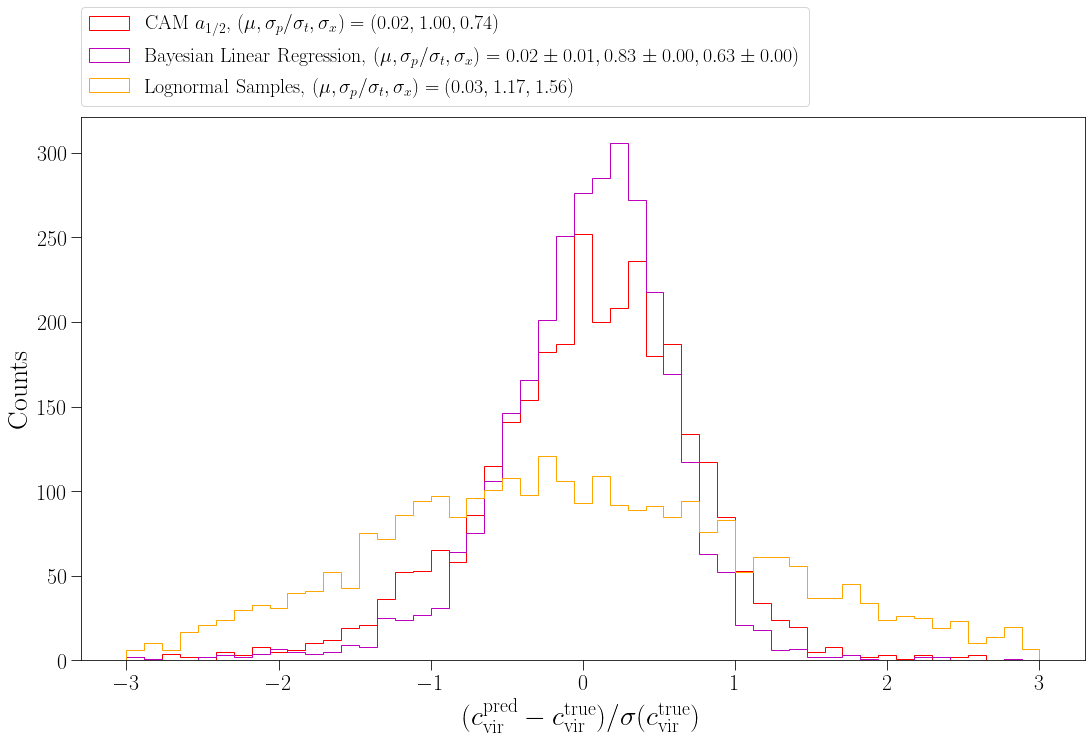

In [180]:
test_data = {'cam_1/2': (am_test, "\\rm CAM $a_{1/2}$", 'r'),
            'blinear': (am_test, "\\rm Bayesian Linear Regression", 'm'),
            'lognormal': (am_test, "\\rm Lognormal Samples", 'orange'),
            }

combined_histogram(test_data, cvir_test, cvir_models, latex_var=r'c_{\rm vir}', n_bins=51, xrange=(-3, 3), cat_test=cat_test, figsize=(18, 10), draw_vline=False)

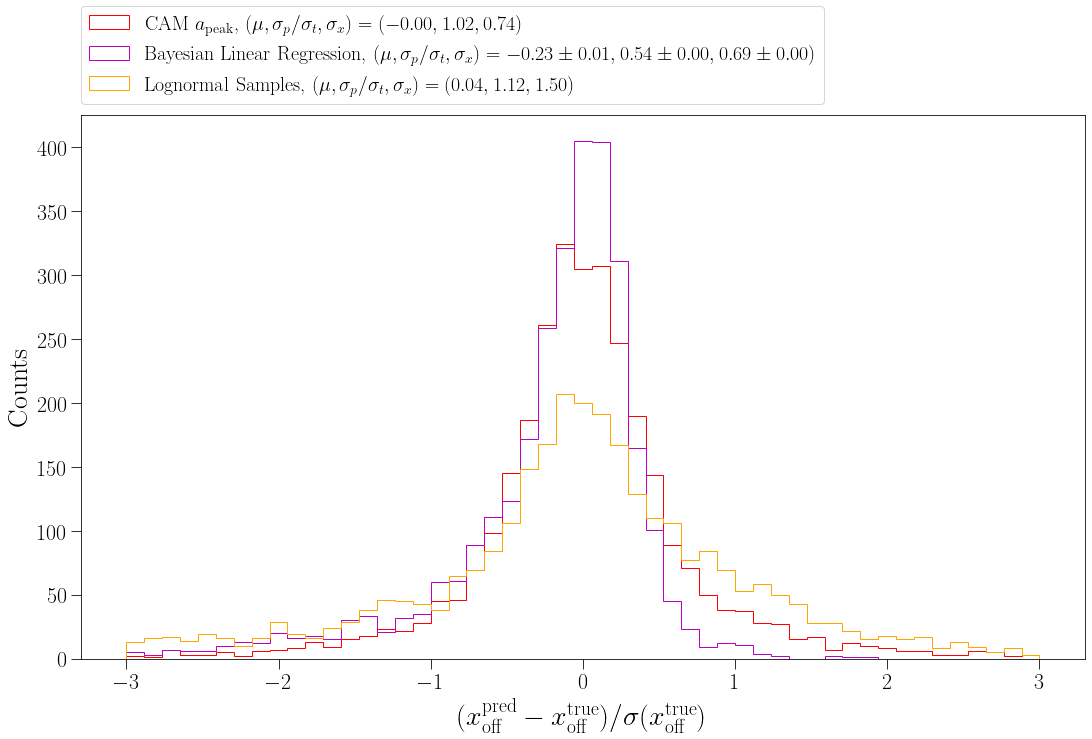

In [183]:
test_data = {'cam_peak': (am_test, "\\rm CAM $a_{\\rm peak}$", 'r'),
            'blinear': (am_test, "\\rm Bayesian Linear Regression", 'm'),
            'lognormal': (am_test, "\\rm Lognormal Samples", 'orange'),
            }

combined_histogram(test_data, xoff_test, xoff_models, latex_var=r'x_{\rm off}', n_bins=51, xrange=(-3, 3),
                   cat_test=cat_test, figsize=(18, 10), draw_vline=False)

## Sampling

In [145]:
cvir_samples = joint_models['blinear_cvir'].sample(am, 1000)[:, :, 0]

print(np.std(cvir_samples))
print(np.mean(cvir_samples))
print(np.std(cvir))
print(np.mean(cvir))

3.865074630858699
9.380817413907147
3.451122222530739
9.215915499544144


In [146]:
xoff_samples = joint_models['blinear_xoff'].sample(am, 1000)[:, :, 0]

print(np.std(xoff_samples))
print(np.mean(xoff_samples))
print(np.std(xoff))
print(np.mean(xoff))

9.091625962084537
9.538747656334174
9.855390280908368
10.165879690524935


## corner plot 

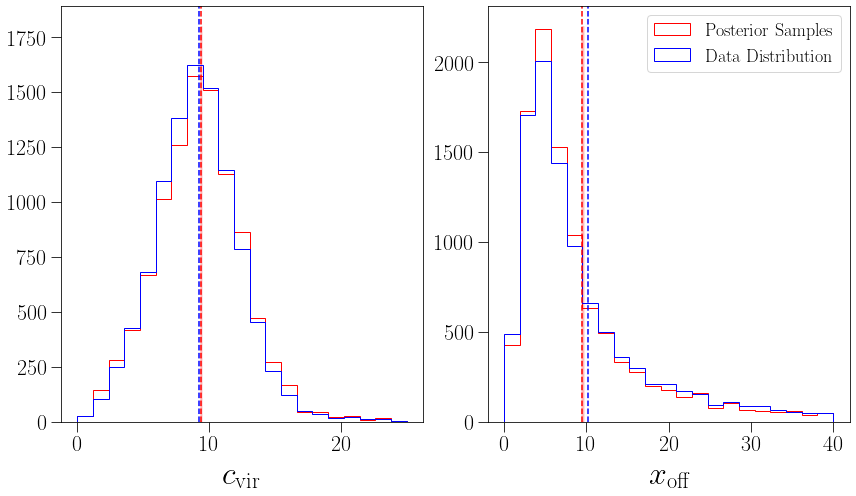

In [188]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
ax1, ax2 = axes.flatten()
n, bins, _ = ax1.hist(cvir_samples[:, 0], bins=21, histtype='step', color='r', range=(0, 25), label=r"\rm Posterior Samples")
ax1.hist(cvir, bins=bins, histtype='step', color='b', label=r'\rm True')
ax1.set_xlabel(r'$c_{\rm vir}$', size=32)
ax1.axvline(cvir.mean(),ymax=1.0, linestyle='dashed', color='b')
ax1.axvline(cvir_samples.mean(), ymax=1.0, linestyle='dashed', color='r')

mean_error = cvir_samples.mean(axis=0).std()
ax1.fill_betweenx(np.arange(0, 1800), cvir_samples.mean() - 2 * mean_error, cvir_samples.mean() + 2 * mean_error,
                 color='r', alpha=0.2)



n, bins, _ = ax2.hist(xoff_samples[:, 0], bins=21, histtype='step', color='r', range=(0, 40), label=r'\rm Posterior Samples')
ax2.hist(xoff, bins=bins, histtype='step', color='b', label=r'\rm Data Distribution')
ax2.legend(loc='best', prop={'size':18})
ax2.set_xlabel(r'$x_{\rm off}$', size=32)
ax2.axvline(xoff.mean(), linestyle='dashed', color='b')
ax2.axvline(xoff_samples.mean(), linestyle='dashed', color='r')

mean_error = xoff_samples.mean(axis=0).std()
ax2.fill_betweenx(np.arange(0, 2200), xoff_samples.mean() - 2 * mean_error, xoff_samples.mean() + 2 * mean_error,
                 color='r', alpha=0.2)

plt.tight_layout()

## Correlation with mean of regression coefficients

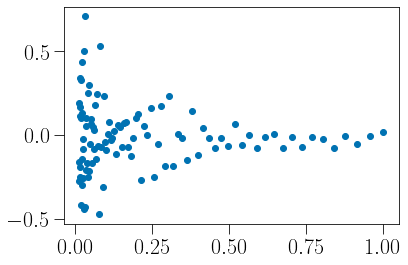

In [117]:
plt.scatter(mass_bins, joint_models['blinear_cvir'].mu)

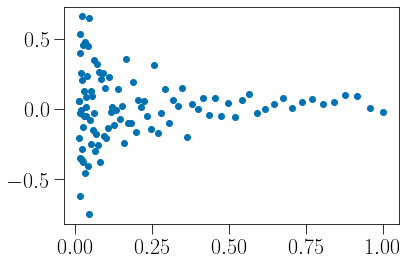

In [118]:
plt.scatter(mass_bins, joint_models['blinear_xoff'].mu)